I have time-series measurements from a transient phenomenon. The model that describes my data is

$y = b$ for $t < t_0$

$y = b + A\exp[-\alpha(t-t_0)]$ for $t\geq t_0$

where where $b$ is the background amplitude, $A$ is the burst amplitude, $t_0$ is the burst epoch, and $\alpha$ encodes how rapidly the burst dies off.

I generate a MCMC chain of posterior probability samples for the joint parameter space of $\{b,A,t_0,\alpha\}$. I perform burn-in and thinning and I analyze the results.



In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import os
import scipy.optimize as opt
import scipy.stats as st

import emcee

# Exploration of the data

 I read the file containing the measurements. The first column is time (arbitrary units), the second column is the flux (arbitrary units), and the third column are homoescedastic measurement uncertainties on the flux.

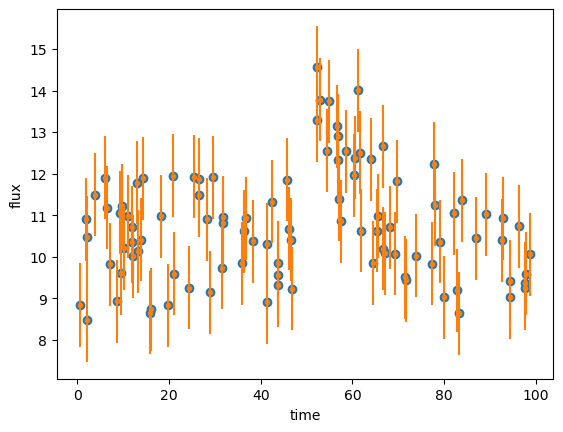

In [2]:
# I read and represent the data
data = np.load("transient.npy")

time = np.zeros(len(data))
flux = np.zeros(len(data))
error_flux = np.zeros(len(data))
for i in range (0, len(data)):
   time[i] = data[i][0]
   flux[i] = data[i][1]
   error_flux[i] = data[i][2]

plt.plot(time, flux, 'o')
plt.errorbar(time, flux, yerr=error_flux, fmt='.')
plt.xlabel('time')
plt.ylabel('flux')
plt.show()

# MCMC

To perform the MCMC I define the following functions:
- the model function
- the log_likelihood function
- the prior function (my priors are: $b\in \mathrm{Uniform}[0,50]$, $A\in \mathrm{Uniform}[0,50]$, $t_0\in \mathrm{Uniform}[0,100]$, $\ln\alpha\in \mathrm{Uniform}[-5,5]$)
- the log_posterior function (log_posterior = log_likelihood + log_prior)

In [3]:
# in the next functions, x is the data array
b = 10
A = 5
t_0 = 50
alp = 0.12
para = [alp, b, t_0, A]  # first guesses for the parameters

def model(para, x):
    y = np.zeros(len(x))
    for i in range (len(x)):
      if x[i] < para[2]:
        y[i] = para[1]
      elif x[i] >= para[2]:
        y[i] = para[1] + para[3]*np.exp(-para[0]*(x[i]-para[2]))
    return y

def ln_likelihood (para, x):
   return -0.5*np.sum((flux - model(para, x))**2/error_flux**2 + np.log(2*np.pi*error_flux**2))

def Prior(para):
   if para[0] <= 0:
      return 0
   
   prior_alp = st.uniform.pdf(np.log(para[0]), loc=-5, scale=10) * 1/para[0]
   prior_b = st.uniform.pdf(para[1], loc=0, scale=50)
   prior_t0 = st.uniform.pdf(para[2], loc=0, scale=100)
   prior_A = st.uniform.pdf(para[3], loc=0, scale=50)
   prior = prior_alp*prior_b*prior_t0*prior_A

   if prior == 0:
      return 0
   
   return prior

def ln_Posterior(para, x):
   if not np.isfinite(np.log(Prior(para))):
      return -np.inf
   
   if not np.isfinite(ln_likelihood(para, x)):
      return -np.inf
   
   return ln_likelihood(para, x) + np.log(Prior(para))

I run the MCMC

In [4]:
ndim = 4  # number of parameters in the model
nwalkers = 10  # number of MCMC walkers
burn = 10000  # "burn-in" period to let chains stabilize
nsteps = 70000  # number of MCMC steps to take for each walker

# initialize parameters
starting_guesses = np.array([alp, b, t_0, A]) + (1e-2)*np.random.random((nwalkers, ndim))

# the function call where all the work happens: 
sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_Posterior, args=[time])
sampler.run_mcmc(starting_guesses, nsteps)
 
# sampler.chain is of shape (nwalkers, nsteps, ndim)
# throw-out the burn-in points and reshape:
emcee_trace  = sampler.chain[:, burn:, :].reshape(-1, ndim)

print("done")

C:\Users\marti\AppData\Local\Temp\ipykernel_20248\2773046250.py:36: RuntimeWarning: divide by zero encountered in log
  if not np.isfinite(np.log(Prior(para))):


done


I plot the traceplots

Text(0.5, 0, 'step number')

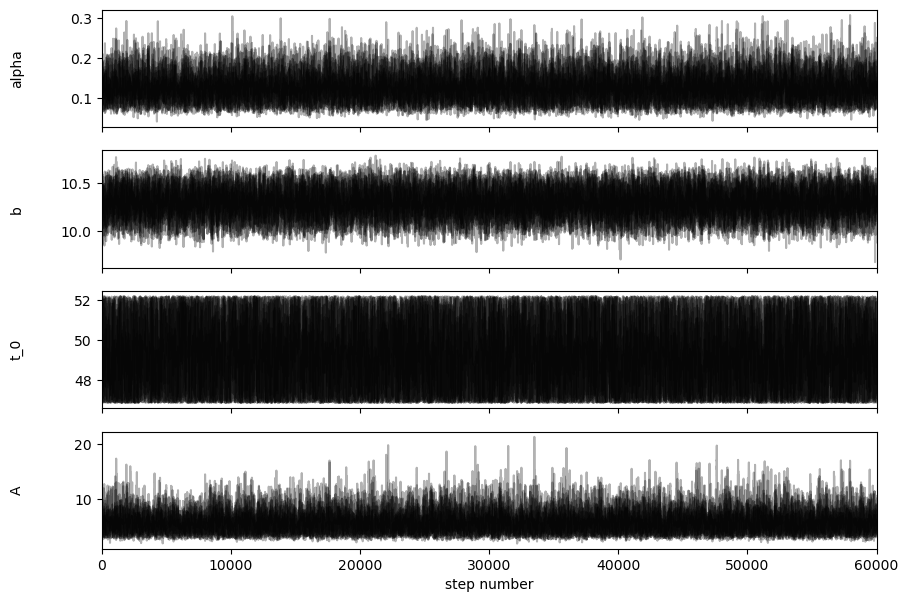

In [5]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.get_chain(discard=burn) # burn-in
labels = ["alpha","b", "t_0", "A"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

I perform thinning on the chain and then I generate a corner plot to visualize the posterior distribution of each parameter.

[74.31707764 67.18145856 93.90040003 92.50940665]
(6450, 4)


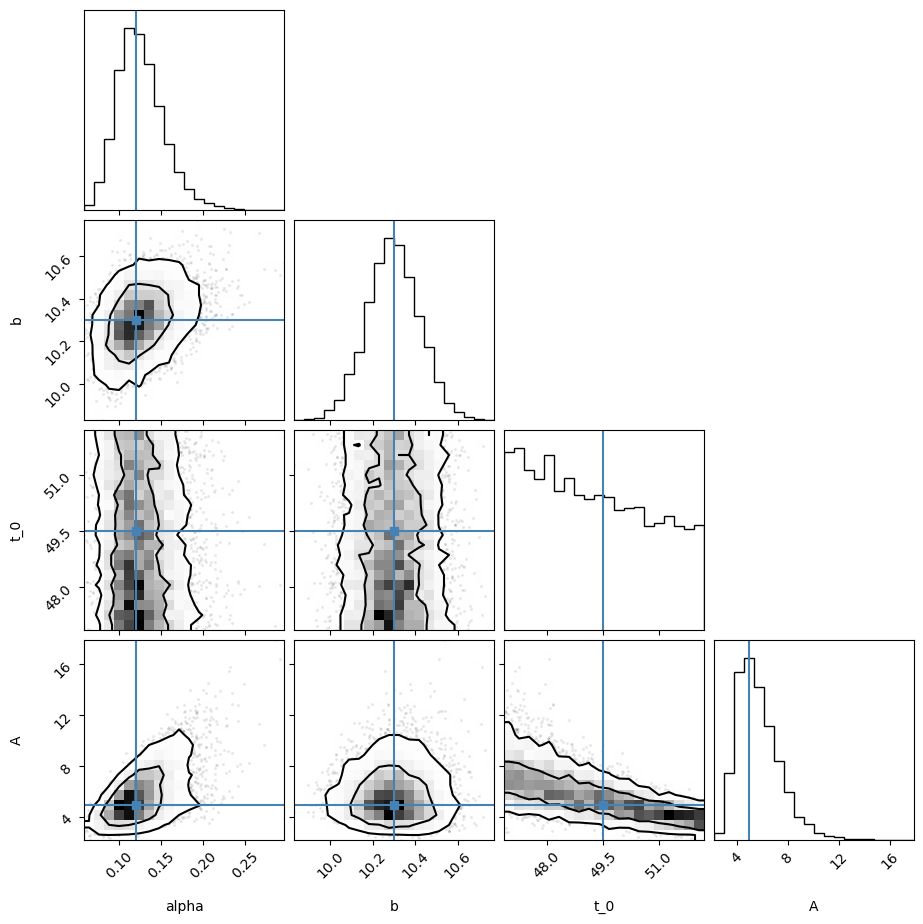

In [7]:
# first corner plot, to try
tau = sampler.get_autocorr_time()
print(tau)

# thinning based on autocorr_time
flat_samples = sampler.get_chain(discard=burn, thin=int(np.max(tau)), flat=True)
print(flat_samples.shape)

import corner
fig = corner.corner(flat_samples, labels=labels, levels=[0.68,0.95], truths=[0.12, 10.3, 49.5, 5])

# Model curves and data

I plot some models on the data, choosing some random samples of the parameters.

Text(0, 0.5, 'flux')

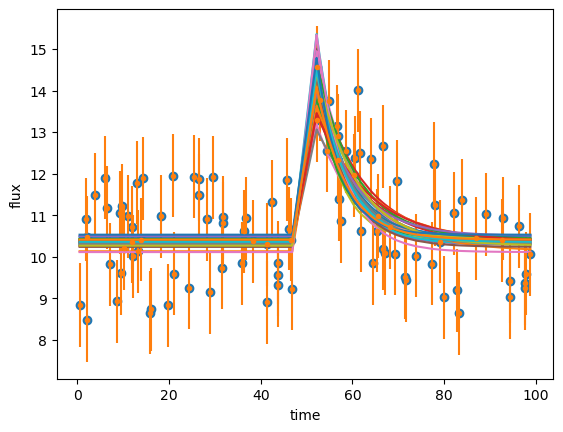

In [8]:
choice_samples= flat_samples[np.random.choice(len(flat_samples),size=30)]

plt.plot(time, flux, 'o')
plt.errorbar(time, flux, yerr=error_flux, fmt='.')

y_models = []
for i in choice_samples:
    y_models.append(model(i, time))
    plt.plot(time, model(i, time))

plt.xlabel('time')
plt.ylabel('flux')

I compute the medians of the parameter samples and I use them to obtain a good model function.

Median of alpha = 0.122157
Median of b = 10.296173
Median of t_0 = 49.120962
Median of A = 5.427141


Text(0, 0.5, 'flux')

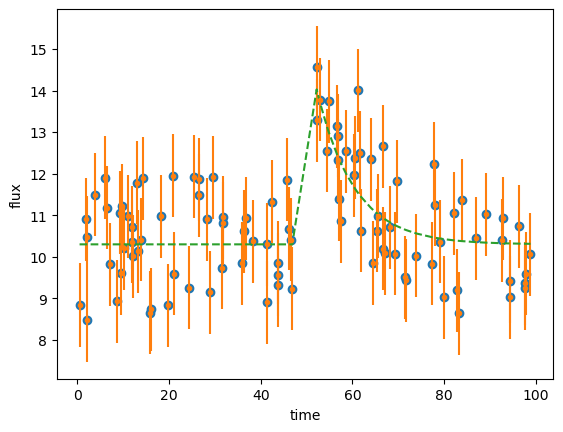

In [9]:
# I save the medians for alpha, b, t_0, A
medians = []
for i in range(len(flat_samples[0])):
    medians.append(np.median(flat_samples[:, i]))
    print('Median of '+ labels[i] + ' = %f' %np.median(flat_samples[:, i]))
    
plt.plot(time, flux, 'o')
plt.errorbar(time, flux, yerr=error_flux, fmt='.')

plt.plot(time, model(medians, time), '--')
plt.xlabel('time')
plt.ylabel('flux')

# Corner plot

[74.31707764 67.18145856 93.90040003 92.50940665]
(6450, 4)


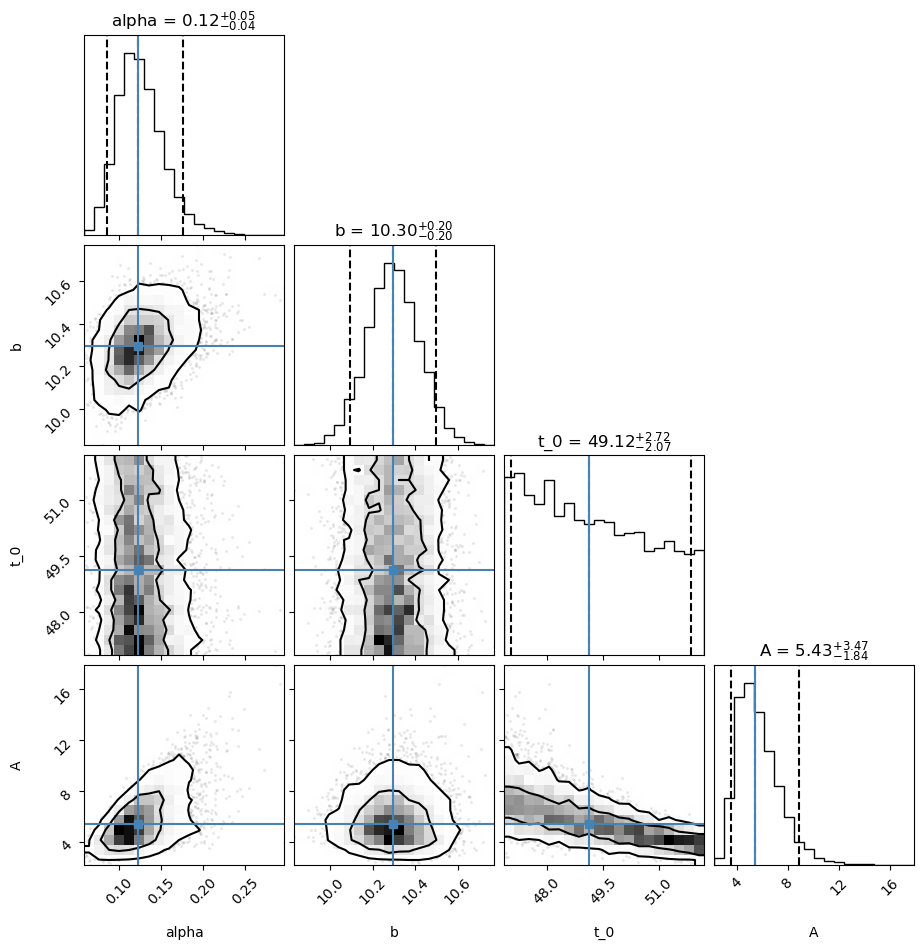

In [10]:
# final corner plot
tau = sampler.get_autocorr_time()
print(tau)

flat_samples = sampler.get_chain(discard=burn, thin=int(np.max(tau)), flat=True)
print(flat_samples.shape)

fig = corner.corner(flat_samples, labels=labels, levels=[0.68, 0.95], truths=medians,
    quantiles=[0.05, 0.5, 0.95],   # 90% credible region
    show_titles=True,
    title_kwargs={"fontsize": 12})